In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [0]:
dataset = pd.read_csv("accepted_2007_to_2018Q4.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
drop_dict = {'id':0, 'earliest_cr_line':0, 'policy_code':0, 'issue_d':0, 'loan_status':0, 'url':0, 'zip_code':0,
             'addr_state':0, 'initial_list_status':0, 'last_pymnt_d':0, 'last_credit_pull_d':0, 'grade':0,
             'sub_grade':0, 'installment':0, 'total_rec_int':0, 'last_pymnt_amnt':0, 'total_pymnt':0, 'total_rec_prncp':0, 'total_pymnt_inv':0}
good_dict = {'emp_length':-1, 'mths_since_last_delinq':-1, 'mths_since_last_record':-1,
            'annual_inc_joint':-1, 'dti_joint':-1, 'open_acc_6m':0, 'open_act_il':0, 'open_il_12m':0,
            'open_il_24m':0, 'all_util':0}
for col in dataset.columns:
    total = dataset.loc[:, col].isnull().sum()
    if total > 20000 and col not in good_dict.keys():
        drop_dict[col] = total
    elif total > 5000 and col not in good_dict.keys():
        print(col, ':', total)

In [0]:
clean = dataset.drop(drop_dict.keys(), axis=1)
for key, val in good_dict.items():
    clean.loc[:, key] = clean.loc[:, key].fillna(val)
clean = clean.dropna()
#drop all rows with missing values (no need to impute because of large amount of data and
#few missing rows of data)

In [0]:
clean.loc[:, 'term'] = pd.to_numeric(clean.loc[:, 'term'].str.replace(' months', ''))
# clean.loc[:, 'zip_code'] = pd.to_numeric(clean.loc[:, 'zip_code'].str.replace('xx', ''))
def len_split(x):
    if type(x) == int:
        return x
    if x.count(' ') == 1:
        val, _ = x.split(' ')
    else:
        _, val, _ = x.split(' ')
    if val[-1] == '+':
        return 10
    else:
        return int(val)
clean.emp_length = clean.emp_length.apply(len_split)

In [0]:
clean.term.unique() #making sure term column is numeric

array([36, 60], dtype=int64)

In [0]:
encodings = ['home_ownership', 'verification_status', 'pymnt_plan',
             'application_type', 'disbursement_method', 'debt_settlement_flag', 'purpose', 'hardship_flag']

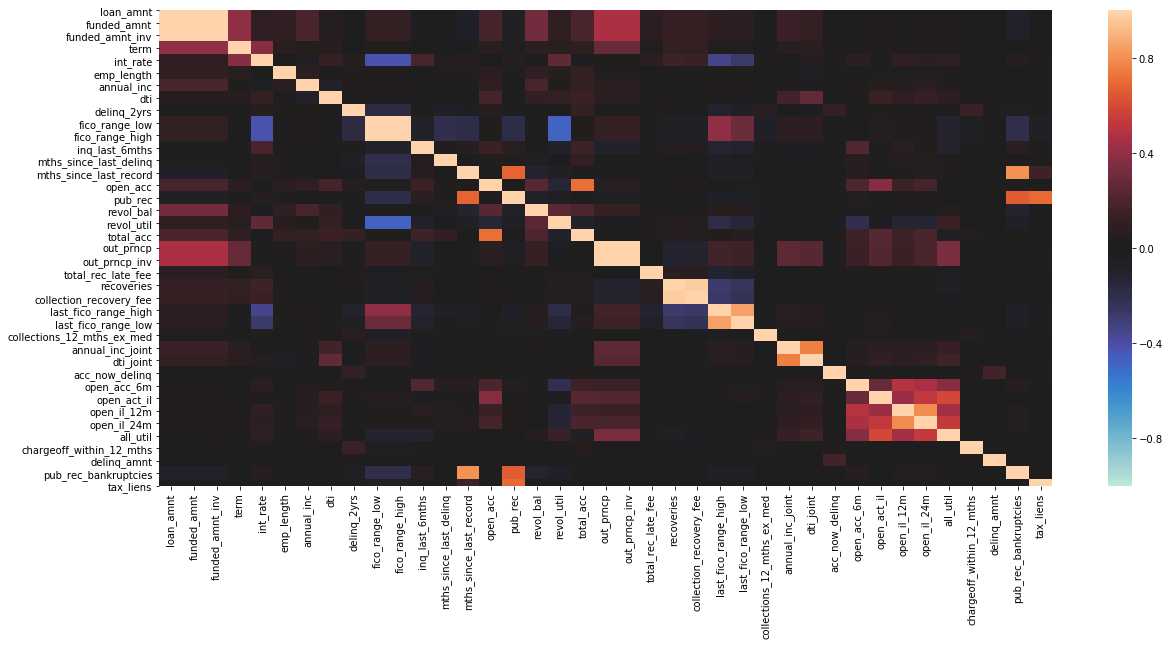

In [0]:
corrdata = clean.drop(encodings, axis=1)
corr = corrdata.corr()
fig, ax = plt.subplots(figsize=(20, 10))
plt.gcf().subplots_adjust(bottom=0.22)
p1 = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, center=0,
            vmin=-1, ax=ax)
# p1 = p1.get_figure()
# p1.savefig('heatmap.png', format='png')

## use label encoder to convert categorical data to numerical for linear regression

In [0]:
clean.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,...,open_il_12m,open_il_24m,all_util,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,10,MORTGAGE,55000.0,Not Verified,n,...,0.0,1.0,34.0,0.0,0.0,0.0,0.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,10,MORTGAGE,65000.0,Not Verified,n,...,0.0,1.0,29.0,0.0,0.0,0.0,0.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,10,MORTGAGE,63000.0,Not Verified,n,...,0.0,4.0,65.0,0.0,0.0,0.0,0.0,N,Cash,N
3,35000.0,35000.0,35000.0,60,14.85,10,MORTGAGE,110000.0,Source Verified,n,...,0.0,1.0,45.0,0.0,0.0,0.0,0.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,3,MORTGAGE,104433.0,Source Verified,n,...,0.0,3.0,78.0,0.0,0.0,0.0,0.0,N,Cash,N


In [0]:
onehot_df = clean[encodings]
onehot_df.shape

(2255820, 8)

In [0]:
enc = OneHotEncoder()
data = enc.fit_transform(onehot_df).toarray()
feature_names = [name_list for name_list in enc.categories_]
col_names = []
for entry, vals in dict(zip(encodings, feature_names)).items():
    for var in vals:
        col_names.append(entry+'_'+var.lower())
encoded = pd.DataFrame(data=data, columns=col_names)
new_data = pd.concat([clean.drop(encodings, axis=1), encoded], axis=1).reset_index(drop=True)
new_data.dropna(inplace=True)
new_data['offset'] = 1

In [0]:
new_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,hardship_flag_n,hardship_flag_y,offset
0,3600.0,3600.0,3600.0,36.0,13.99,10.0,55000.0,5.91,0.0,675.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,24700.0,24700.0,24700.0,36.0,11.99,10.0,65000.0,16.06,1.0,715.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,20000.0,20000.0,20000.0,60.0,10.78,10.0,63000.0,10.78,0.0,695.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,35000.0,35000.0,35000.0,60.0,14.85,10.0,110000.0,17.06,0.0,785.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,10400.0,10400.0,10400.0,60.0,22.45,3.0,104433.0,25.37,1.0,695.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [0]:
predictors = new_data.drop(['int_rate'],axis = 1)
predictors = predictors.iloc[0:int(len(new_data)*.5)]

In [0]:
train_target = new_data['int_rate']
#train_target = train_target.iloc[0:]
train_target = train_target.iloc[0:int(len(new_data)*.5)]

In [0]:
print(len(train_target))
print(len(predictors))

1125474
1125474


In [0]:
# instantiate linear regression object
ridge = RidgeCV(alphas=[0.1], cv=5, gcv_mode='eigen')

# fit or train the linear regression model on the training set and store parameters
ridge.fit(predictors, train_target)

# show the alpha parameter used in final ridgeCV model
ridge.alpha_

# show the coefficients of each variable
# ridge.coef_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.53513e-18): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.37e-18): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.59991e-17): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.17156e-18): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.47101e-18): result may not be accurate.
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridg

0.1

In [0]:
ridge.intercept_

29.895899838854156

In [0]:
train_pred = ridge.predict(predictors)

#ridge_test_pred = ridge.predict(test)

# print RMSE of training predictions
print('MAE on training data: ', mean_absolute_error(train_target, train_pred))

MAE on training data:  2.824676420815675


for i in range(0,int(len(clean)*.8)):
    print(train_target[i], train_pred[i])

In [0]:
test_predictors = new_data.drop(['int_rate'],axis = 1)
test_predictors = test_predictors.iloc[int(len(new_data)*.5):]

In [0]:
test_target = new_data['int_rate']
#train_target = train_target.iloc[0:]
test_target = test_target.iloc[int(len(new_data)*.5):]

In [0]:
ridge_test_pred = ridge.predict(test_predictors)

In [0]:
print('MAE on test data: ', mean_absolute_error(test_target, ridge_test_pred))

MAE on test data:  2.874241589178592


columns = dataset.columns
for i in columns:
    print(i)

In [0]:
import xgboost as xgb
from xgboost import plot_importance

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import safe_indexing, indexable
from itertools import chain

In [0]:
# split training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    predictors,
    train_target,
    test_size=.2,
    random_state=42)

In [0]:
# xgb models only accept 'DMatrix' input; convert the data here
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [0]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [0]:
# parameter grid for xgb model
param_list = {
    'max_depth': 10, 
    'min_child_weight': 2,
    'eta':2.1,
    'subsample': 0.5,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'max_delta_step': 0.5,
    'lambda': 2,
    'alpha': 1,
    'scale_pos_weight': 1.5,
    'predictor': 'cpu_predictor',
    'eval_metric': 'mae'
}

In [0]:
# train XGB model on split training data using split test data
num_boost_round=30
mod = xgb.train(param_list,dtrain,num_boost_round=num_boost_round,evals=[(dtest, "Test")], early_stopping_rounds = 10)

[0]	Test-mae:11.2054
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:10.1554
[2]	Test-mae:9.10537
[3]	Test-mae:8.05537
[4]	Test-mae:7.03327
[5]	Test-mae:6.09074
[6]	Test-mae:5.28792
[7]	Test-mae:4.65391
[8]	Test-mae:4.1086
[9]	Test-mae:3.68647
[10]	Test-mae:3.38316
[11]	Test-mae:3.20682
[12]	Test-mae:3.01205
[13]	Test-mae:2.91493
[14]	Test-mae:2.85392
[15]	Test-mae:2.82581
[16]	Test-mae:2.81869
[17]	Test-mae:2.80769
[18]	Test-mae:2.81623
[19]	Test-mae:2.81853
[20]	Test-mae:2.82903
[21]	Test-mae:2.83328
[22]	Test-mae:2.84862
[23]	Test-mae:2.85606
[24]	Test-mae:2.87992
[25]	Test-mae:2.88293
[26]	Test-mae:2.90463
[27]	Test-mae:2.90895
Stopping. Best iteration:
[17]	Test-mae:2.80769



In [0]:
print("Model's best MAE on test set: ", mod.best_score)
print("Model's best iteration: ", mod.best_iteration+1)

Model's best MAE on test set:  2.807691
Model's best iteration:  18


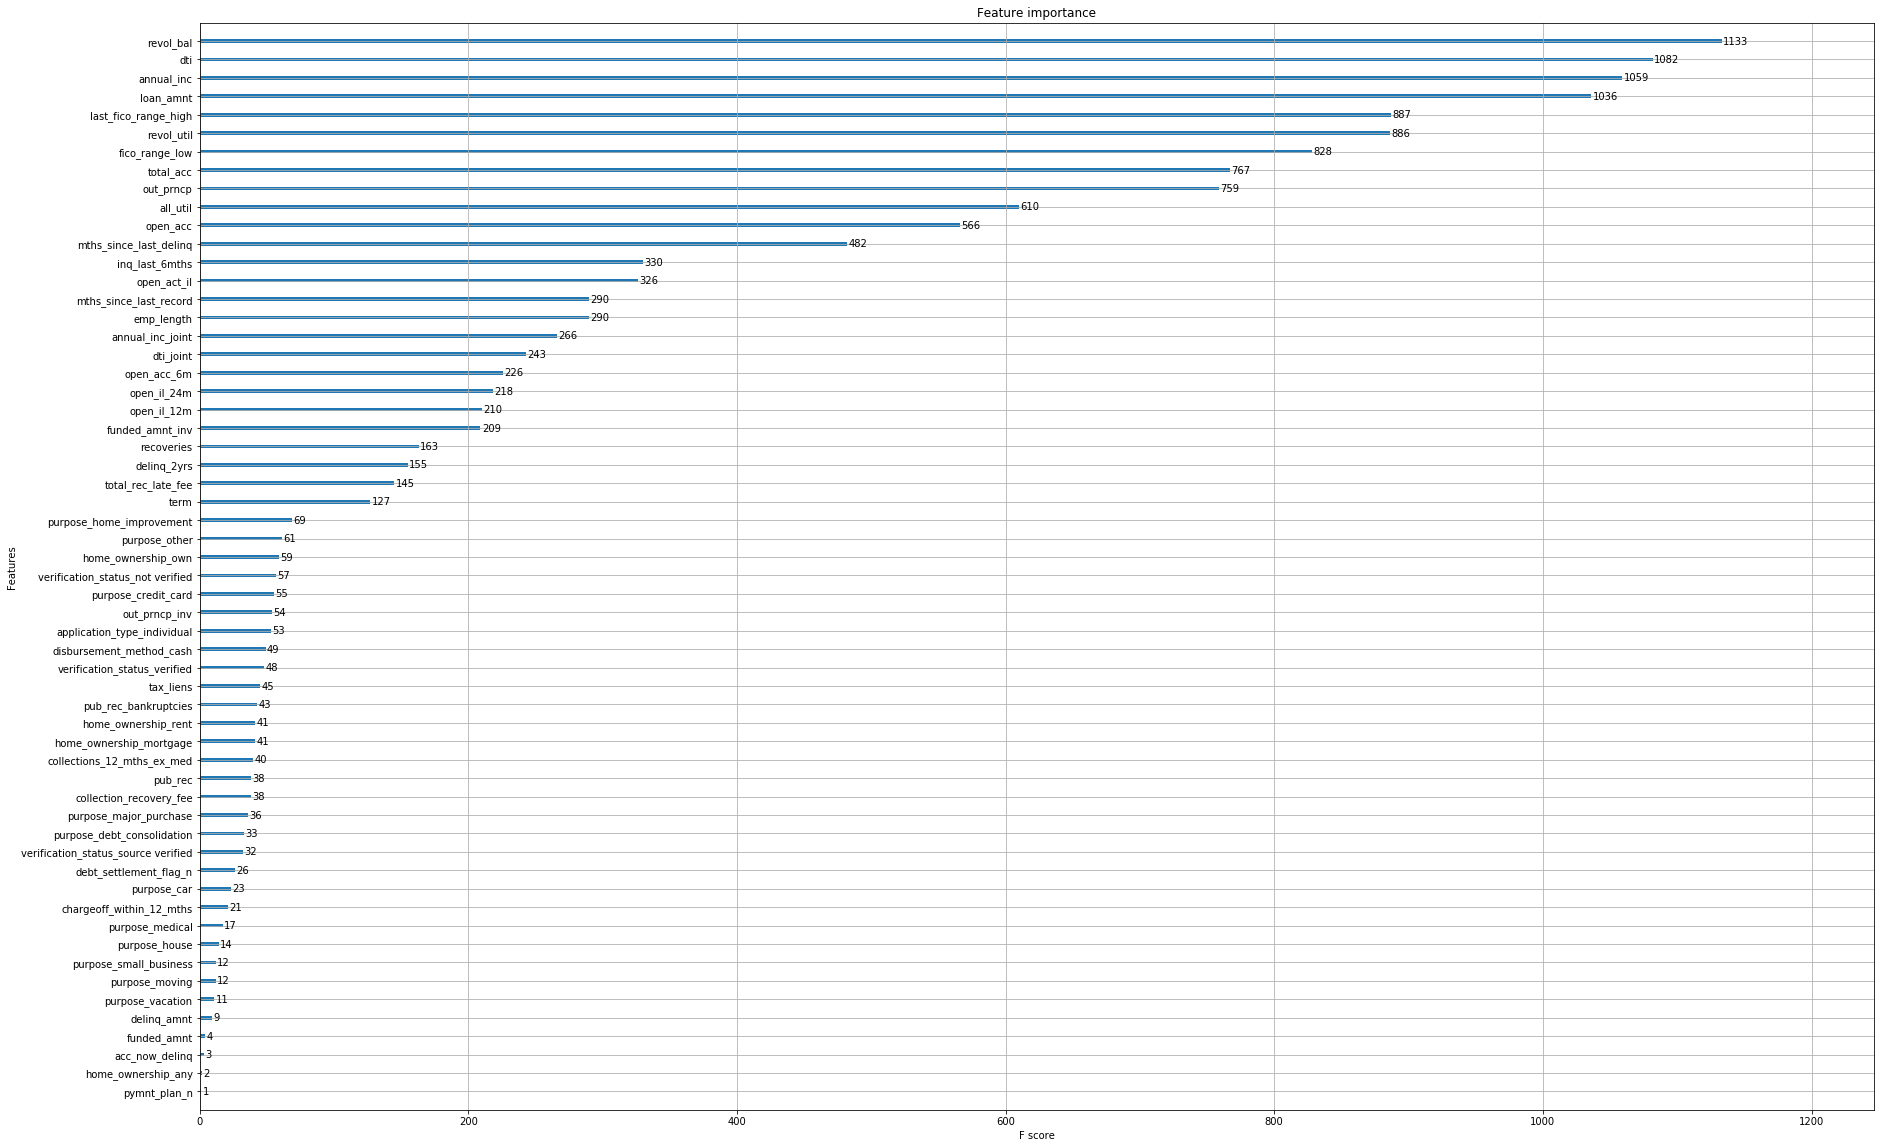

In [0]:
fig, ax = plt.subplots(figsize=(30, 20))
xgb.plot_importance(mod, ax=ax)
# xgb.plot_tree(mod)

## Parameter Tuning

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [0]:
# split = int(len(clean) * 0.05)
split=30000
train = new_data.iloc[:split, :]
test = new_data.iloc[split:, :]
unused = ['grade', 'sub_grade']
target = 'int_rate'

In [0]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgbtrain = xgb.DMatrix(dtrain.loc[:, predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgbtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                         metrics='mae', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    alg.fit(dtrain.loc[:, predictors], dtrain.loc[:, 'int_rate'], eval_metric='mae', )
    
    dtrain_predictions = alg.predict(dtrain.loc[:, predictors])
#     dtrain_predprob = alg.predict_proba(dtrain.loc[:, predictors])[:, 1]
    
    print('\nModel Report')
    # print('Accuracy: {}'.format(alg.score(dtrain.loc[:, 'int_rate'].values, dtrain_predictions)))
    print('MAE Score (Train): {}'.format(mean_absolute_error(dtrain.loc[:, 'int_rate'], dtrain_predictions)))
    fig, ax = plt.subplots(figsize=(20, 10))
    xgb.plot_importance(alg, ax=ax)
    plt.ylabel('Feature Importance Score')


Model Report
MAE Score (Train): 1.3011571655953724


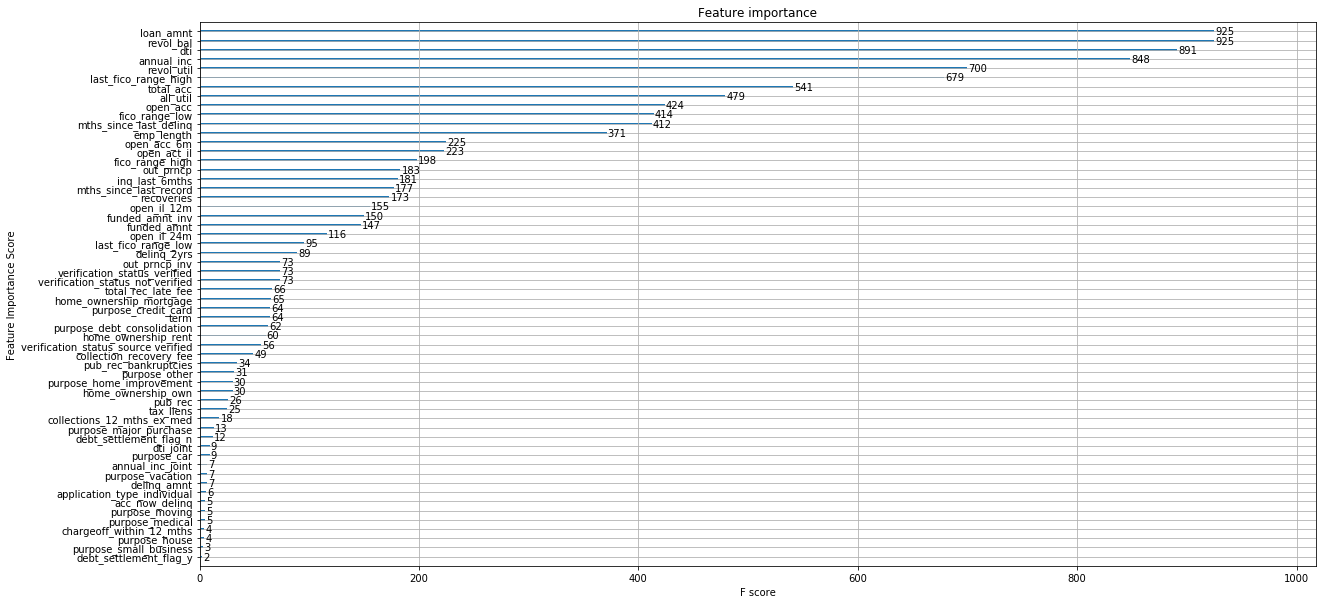

In [0]:
predictors = [x for x in train.columns if (x not in unused or x != target)]
predictors.remove(target)
xgb1 = XGBRegressor(learning_rate=0.3, n_estimators=1000, max_depth=10, min_child_weight=2, gamma=0.2,
                    subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror', nthread=4, scale_pos_weight=1, silent=False)
# xgb1.get_params()
modelfit(xgb1, train, predictors)

In [0]:
# xgb1.score(train.loc[:, predictors], xgb1.predict(train.loc[:, predictors]))
pred = xgb1.predict(test.loc[:, predictors])
mean_absolute_error(test.int_rate, pred)

2.9990213604073115

In [0]:
xgb1.get_num_boosting_rounds()

26

In [0]:
param_test1 = {
    'max_depth':range(5, 9, 2),
    'min_child_weight':range(1, 5, 2)
}

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.3, n_estimators=30, max_depth=10, 
                                                min_child_weight=2, gamma=0.2, subsample=0.8,
                                                colsample_bytree=0.8, objective='reg:squarederror',
                                                nthread=4, scale_pos_weight=1, silent=False),
                        param_grid=param_test1, scoring='neg_mean_absolute_error', n_jobs=-1, iid=False, cv=5)
gsearch1.fit(train[predictors], train.int_rate)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

AttributeError: ignored

In [0]:
mean_absolute_error(test.int_rate, gsearch1.predict(test[predictors]))

3.4155630118309848

In [0]:
print(gsearch1.best_estimator_)
print(gsearch1.best_score_)
print(gsearch1.best_params_)
print(gsearch1.best_index_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.3, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=30, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)
-2.511876
{'max_depth': 7, 'min_child_weight': 3}
3


In [0]:
param_test2 = {
    'max_depth':[6, 7, 8],
    'min_child_weight':[2, 3, 4]
}

gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.3, n_estimators=30, max_depth=10, 
                                                min_child_weight=2, gamma=0.2, subsample=0.8,
                                                colsample_bytree=0.8, objective='reg:squarederror',
                                                nthread=4, scale_pos_weight=1, silent=False),
                        param_grid=param_test2, scoring='neg_mean_absolute_error', n_jobs=-1, iid=False, cv=5)
gsearch2.fit(train[predictors], train.int_rate)
print(gsearch2.best_estimator_)
print(gsearch2.best_score_)
print(gsearch2.best_params_)
print(gsearch2.best_index_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.3, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=30, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)
-2.511876
{'max_depth': 7, 'min_child_weight': 3}
3


In [0]:
print(gsearch2.best_estimator_)
print(gsearch2.best_score_)
print(gsearch2.best_params_)
print(gsearch2.best_index_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=None, n_estimators=30, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)
-2.5064556666666666
{'max_depth': 6, 'min_child_weight': 4}
2


In [0]:
param_test2b = {
    'max_depth':[6, 5],
    'min_child_weight':[4,5]
}

gsearch2b = GridSearchCV(estimator=XGBClassifier(learning_rate=0.3, n_estimators=30, max_depth=10, 
                                                min_child_weight=2, gamma=0.2, subsample=0.8,
                                                colsample_bytree=0.8, objective='reg:squarederror',
                                                nthread=4, scale_pos_weight=1, silent=False),
                        param_grid=param_test2, scoring='neg_mean_absolute_error', n_jobs=-1, iid=False, cv=5)
gsearch2b.fit(train[predictors], train.int_rate)
print(gsearch2b.best_estimator_)
print(gsearch2b.best_score_)
print(gsearch2b.best_params_)
print(gsearch2b.best_index_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=None, n_estimators=30, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)
-2.5064556666666666
{'max_depth': 6, 'min_child_weight': 4}
2


In [0]:
param_test3 = {
    'gamma': [i/10 for i in range(10)]
}

gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.3, n_estimators=30, max_depth=6, 
                                                min_child_weight=4, gamma=0.2, subsample=0.8,
                                                colsample_bytree=0.8, objective='reg:squarederror',
                                                nthread=4, scale_pos_weight=1, silent=False),
                        param_grid=param_test3, scoring='neg_mean_absolute_error', n_jobs=-1, iid=False, cv=5)
gsearch3.fit(train[predictors], train.int_rate)
print(gsearch3.best_estimator_)
print(gsearch3.best_score_)
print(gsearch3.best_params_)
print(gsearch3.best_index_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.7,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=None, n_estimators=30, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)
-2.5001356666666665
{'gamma': 0.7}
7
